In [ ]:
!pip install python-graphblas[default]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 350.9/350.9 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 MB 14.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import graphblas as gb
from graphblas import Matrix, Vector, Scalar
from graphblas import dtypes
from graphblas import unary, binary, monoid, semiring
from graphblas.io import mmread

# **MSBFS-Levels**

Используя python-graphblas реализовать функцию обхода ориентированного графа (MSBFS-Levels) в ширину из нескольких заданных стартовых вершин.
* Функция принимает представление графа, удобное для неё (загрузка, конвертация реализованы отдельно) и массив номеров стартовых вершин.
* Функция возвращает массив пар: стартовая вершина, и массив (levels), где для каждой вершины указано, на каком уровне она достижима из этой стартовой. Стартовая вершина достижима на нулевом уровне, если вершина не достижима, то значение соответствующей ячейки сделайте равной -1.

In [ ]:
def level_BFS(A, massiv):
  # количество вершин в графе
  n = A.nrows
  # количество стартовых вершин
  m = len(massiv)
  # матрица для результата с уровнями для каждой стартовой вершины
  result = Matrix(dtypes.INT32, m, n)  # vector for result with levels
  # фронт
  f = Matrix(bool, m, n)
  # заполние изначальной матрицы значениями для каждой стартовой вершины
  for i in range(m):
    f[i, massiv[i]] << True
  # вектор перехода к доступным вершинам из текущей
  succ = Vector(bool, m)
  # уровень начальный
  level = 0
  # создание цикла для обхода графа
  while True:
    # уровень для стартовых вершин по маске f
    result(mask=f.V) << level
    # рассчет следующего фронта
    f(~result.S, replace=True) << f.mxm(A, semiring.lor_land)
    # заполнение вектора перехода к доступным вершинам для каждой из стартовых вершин
    for i in range(m):
      succ[i] << f[i,:].reduce(monoid.lor, allow_empty=False)
    # остановка цикла, если дальше нет вершин для перехода
    # если есть хотя бы одно True, то значит дальше можно не проверять
    for i in range(m):
      if succ[i]:
        break
    # если все False значит граф полностью обошли
    if not succ[i]:
      break
    # переходим на следующий уровень
    level += 1
  # создание массива пар с помощью словаря, где ключ - стартовая вершина, значение - массив (levels), где указано, на каком уровне каждая вершина достижима из текущей стартовой вершины
  final = dict() # словарь
  for i in range(0, m):
    values = [] # массив levels
    for j in range(0, n):
      if result[i, j].value is None:
        values.append(-1) # -1, если вершина не достижима
      else:
        values.append(result[i, j].value)
    final[massiv[i]] = values
  return final

# **MSBFS-Parents**

Используя python-graphblas реализовать функцию обхода ориентированного графа (MSBFS-Parents) в ширину из нескольких заданных стартовых вершин.
* Функция принимает представление графа, удобное для неё (загрузка, конвертация реализованы отдельно) и массив номеров стартовых вершин.
* Функция возвращает массив пар: стартовая вершина, и массив (parents), где для каждой вершины графа указано, из какой вершины мы пришли в эту по кратчайшему пути из стартовой вершины. При этом для самой стартовой вершины такое значение взять равное -1, а для недостижимых вершин взять равное -2. При наличии нескольких возможных значений в массивах parents брать наименьшее

In [ ]:
def parent_BFS(A, massiv):
  # количество вершин в графе
  n = A.nrows
  # количество стартовых вершин
  m = len(massiv)
  # матрица для результата с индентификаторами вершин
  index_ramp = Matrix(dtypes.UINT64, m, n)
  # заполнение матрицы текущими номерами вершин
  for i in range(m):
    for j in range(n):
      index_ramp[i,j] << j
  # создание массива "родителей"
  parents = Matrix(dtypes.UINT64, m, n)
  # фронт
  wavefront = Matrix(dtypes.UINT64, m, n)
  # заполнение матрицы номерами соответвующих вершин "родителей"
  for i in range(m):
    parents[i,massiv[i]] << massiv[i]
    wavefront[i, massiv[i]] << 1
  # создание цикла для обхода графа
  while wavefront.nvals > 0:
    # конвертирование сохраненных значений фронта в индексы значений
    wavefront << index_ramp.ewise_mult(wavefront, binary.first)
    # маскирование "родителей"
    wavefront (~parents.S, replace=True) << wavefront.mxm(A, semiring.min_first)
    # объединение существующих "родителей" с новыми из фронта
    parents(binary.plus) << wavefront
# создание массива пар с помощью словаря, где ключ - стартовая вершина, значение - массив (parents), где указано, из какой вершины мы пришли в эту по кратчайшему пути из стартовой вершины
  final = dict() # словарь
  for i in range(m):
    values = [] # значения
    for j in range(n):
      if parents[i, j].value is None:
        values.append(-2) # -2 для недостижимых вершин
      elif j == massiv[i]:
        values.append(-1) # -1 для стартовых вершин
      else:
        values.append(parents[i,j].value)
    final[massiv[i]] = values
  return final

# **Тестирование**

**TEST 1**

Все вершины достижимы из любой вершины

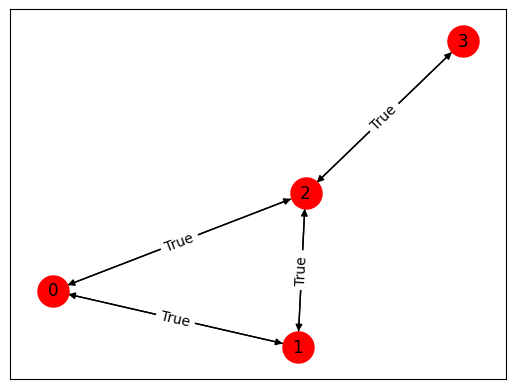

In [ ]:
edges = [
  [0, 1, 1, 2, 2, 0, 2, 3],
  [1, 0, 2, 1, 0, 2, 3, 2],
]
M1 = Matrix.from_coo(edges[0], edges[1], [True for _ in edges[0]])
gb.viz.draw(M1)

In [ ]:
# стартовые вершины 0 и 1
p = [0, 1]
# правильные ответы
a1 = {0: [0, 1, 1, 2], 1: [1, 0, 1, 2]}
a2 = {0: [-1, 0, 0, 2], 1: [1, -1, 1, 2]}

print('level_BFS:', level_BFS(M1, p))
print('parent_BFS:', parent_BFS(M1, p))

if level_BFS(M1, p) == a1 and parent_BFS(M1, p) == a2:
  print('Test passed')
else:
  print('Test failed')

level_BFS: {0: [0, 1, 1, 2], 1: [1, 0, 1, 2]}
parent_BFS: {0: [-1, 0, 0, 2], 1: [1, -1, 1, 2]}
Test passed


**TEST 2**

Одна вершина не достижима из всех вершин, а вторая вершина достижима из любой вершины

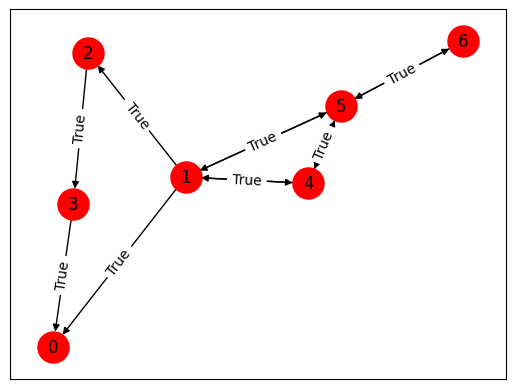

In [ ]:
edges = [
  [1, 1, 2, 3, 1, 4, 5, 5, 5, 4, 1, 6],
  [0, 2, 3, 0, 4, 5, 1, 6, 4, 1, 5, 5],
]
M2 = Matrix.from_coo(edges[0], edges[1], [True for _ in edges[0]])
gb.viz.draw(M2)

In [ ]:
# стартовые вершины 0 и 1
p = [0, 1]
# правильные ответы
a1 = {0: [0, -1, -1, -1, -1, -1, -1], 1: [1, 0, 1, 2, 1, 1, 2]}
a2 = {0: [-1, -2, -2, -2, -2, -2, -2], 1: [1, -1, 1, 2, 1, 1, 5]}

print('level_BFS:', level_BFS(M2, p))
print('parent_BFS:', parent_BFS(M2, p))

if level_BFS(M2, p) == a1 and parent_BFS(M2, p) == a2:
  print('Test passed')
else:
  print('Test failed')

level_BFS: {0: [0, -1, -1, -1, -1, -1, -1], 1: [1, 0, 1, 2, 1, 1, 2]}
parent_BFS: {0: [-1, -2, -2, -2, -2, -2, -2], 1: [1, -1, 1, 2, 1, 1, 5]}
Test passed


**TEST 3**

Увеличим количество стартовых вершин - все будут достижимы

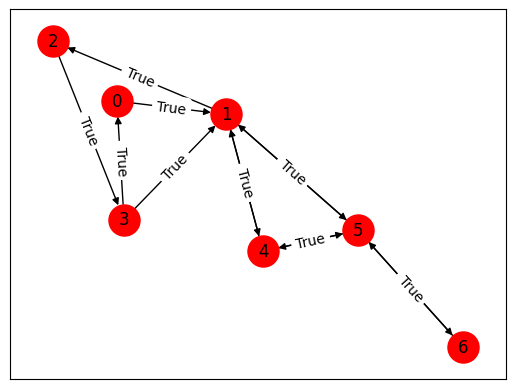

In [ ]:
edges = [
  [1, 2, 3, 1, 4, 5, 5, 5, 4, 1, 6, 0, 3],
  [2, 3, 0, 4, 5, 1, 6, 4, 1, 5, 5, 1, 1],
]
M3 = Matrix.from_coo(edges[0], edges[1], [True for _ in edges[0]])
gb.viz.draw(M3)

In [ ]:
# стартовые вершины 0, 1, 5 и 6
p = [0, 1, 5, 6]
# правильные ответы
a1 = {0: [0, 1, 2, 3, 2, 2, 3], 1: [3, 0, 1, 2, 1, 1, 2], 5: [4, 1, 2, 3, 1, 0, 1], 6: [5, 2, 3, 4, 2, 1, 0]}
a2 = {0: [-1, 0, 1, 2, 1, 1, 5], 1: [3, -1, 1, 2, 1, 1, 5], 5: [3, 5, 1, 2, 5, -1, 5], 6: [3, 5, 1, 2, 5, 6, -1]}

print('level_BFS:', level_BFS(M3, p))
print('parent_BFS:', parent_BFS(M3, p))

if level_BFS(M3, p) == a1 and parent_BFS(M3, p) == a2:
  print('Test passed')
else:
  print('Test failed')

level_BFS: {0: [0, 1, 2, 3, 2, 2, 3], 1: [3, 0, 1, 2, 1, 1, 2], 5: [4, 1, 2, 3, 1, 0, 1], 6: [5, 2, 3, 4, 2, 1, 0]}
parent_BFS: {0: [-1, 0, 1, 2, 1, 1, 5], 1: [3, -1, 1, 2, 1, 1, 5], 5: [3, 5, 1, 2, 5, -1, 5], 6: [3, 5, 1, 2, 5, 6, -1]}
Test passed


**TEST 4**


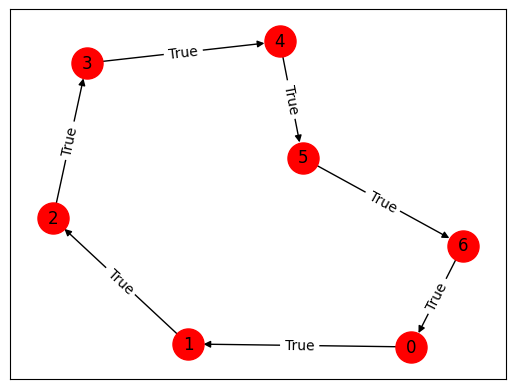

In [ ]:
edges = [
  [0, 1, 2, 3, 4, 5, 6],
  [1, 2, 3, 4, 5, 6, 0],
]
M4 = Matrix.from_coo(edges[0], edges[1], [True for _ in edges[0]])
gb.viz.draw(M4)

In [ ]:
# стартовые вершины 0 и 6
p = [0, 6]
# правильные ответы
a1 = {0: [0, 1, 2, 3, 4, 5, 6], 6: [1, 2, 3, 4, 5, 6, 0]}
a2 = {0: [-1, 0, 1, 2, 3, 4, 5], 6: [6, 0, 1, 2, 3, 4, -1]}

print('level_BFS:', level_BFS(M4, p))
print('parent_BFS:', parent_BFS(M4, p))

if level_BFS(M4, p) == a1 and parent_BFS(M4, p) == a2:
  print('Test passed')
else:
  print('Test failed')

level_BFS: {0: [0, 1, 2, 3, 4, 5, 6], 6: [1, 2, 3, 4, 5, 6, 0]}
parent_BFS: {0: [-1, 0, 1, 2, 3, 4, 5], 6: [6, 0, 1, 2, 3, 4, -1]}
Test passed


**TEST 5**

Совсем немного измненим прошлый граф и уже другой результат

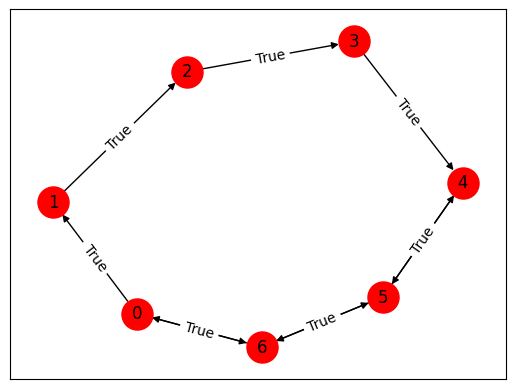

In [ ]:
edges = [
  [0, 1, 2, 3, 4, 5, 6, 0, 6, 5],
  [1, 2, 3, 4, 5, 6, 0, 6, 5, 4],
]
M5 = Matrix.from_coo(edges[0], edges[1], [True for _ in edges[0]])
gb.viz.draw(M5)

In [ ]:
# стартовые вершины 0 и 6
p = [0, 6]
# правильные ответы
a1 = {0: [0, 1, 2, 3, 3, 2, 1], 6: [1, 2, 3, 4, 2, 1, 0]}
a2 = {0: [-1, 0, 1, 2, 5, 6, 0], 6: [6, 0, 1, 2, 5, 6, -1]}

print('level_BFS:', level_BFS(M5, p))
print('parent_BFS:', parent_BFS(M5, p))

if level_BFS(M5, p) == a1 and parent_BFS(M5, p) == a2:
  print('Test passed')
else:
  print('Test failed')

level_BFS: {0: [0, 1, 2, 3, 3, 2, 1], 6: [1, 2, 3, 4, 2, 1, 0]}
parent_BFS: {0: [-1, 0, 1, 2, 5, 6, 0], 6: [6, 0, 1, 2, 5, 6, -1]}
Test passed


# **Дополнительно**

Провести экспериментальное исследование полученных реализаций на некоторых больших графах в формате Matrix Market с сайта SuiteSparse Matrix Collection и на случайных сгенерированных. При этом описать зависимость времени работы всех полученных реализаций от размеров графа, его степени разреженности, количестве стартовых вершин.

**Тестирование на больших графах с сайта SuiteSparse Matrix Collection**

In [ ]:
import random

In [ ]:
# читаем 5 графов
graph1 = mmread('/content/can_838.mtx')
graph2 = mmread('/content/dwt_992.mtx')
graph3 = mmread('/content/can_1054.mtx')
graph4 = mmread('/content/email.mtx')
graph5 = mmread('/content/delaunay_n11.mtx')

# создаем массив графов
graphs = [graph1, graph2, graph3, graph4, graph5]

In [ ]:
# создаем функцию реализации для алгоритмов с подсчетом времени выполнения
def alg_time(A, a):
  print('level_BFS:')
  %timeit level_BFS(A, a)
  print('parent_BFS:')
  %timeit parent_BFS(A, a)

In [ ]:
# создаем функцию для генерации массива стартовых вершин, где n - количество вершин в графе и p - доля генерируемых стартовых вершин
def vertex_generate(n, p):
  population = range(n)
  vertex_array = random.sample(population, round(n * p))
  return np.array(vertex_array)

In [ ]:
# Выводим нужные нам данные для сравнения результатов

gen_vertex = [0.01, 0.05, 0.1, 0.5] # доля генерируемых вершин
for k in graphs:
  print('Количество вершин:', k.nrows, 'Количество ребер:', k.nvals)
  for p in gen_vertex:
    print('Количество стартовых вершин:', round(k.nrows * p))
    print(alg_time(k, vertex_generate(k.nrows, p)))

Количество вершин: 838 Количество ребер: 10010
Количество стартовых вершин: 8
level_BFS:
543 ms ± 12.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
parent_BFS:
738 ms ± 51 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество стартовых вершин: 42
level_BFS:
2.9 s ± 386 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
parent_BFS:
4.14 s ± 402 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество стартовых вершин: 84
level_BFS:
6.13 s ± 478 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
parent_BFS:
9.45 s ± 2.22 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество стартовых вершин: 419
level_BFS:
30.4 s ± 596 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
parent_BFS:
41 s ± 665 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество вершин: 992 Количество ребер: 16744
Количество стартовых вершин: 10
level_BFS:
794 ms ± 9.78 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
parent_BFS:
1.22 s ± 2

**Тестирование на случайно сгенерированных графах с использованием реализации с прошлой лабораторной работы**

In [ ]:
# n_rows - количество вершин графа, density - условно, насколько матрица смежности разряженная
def graph_generator(n_rows, density):
  # создание пустой матрицы размера n_rows на n_rows
  A = gb.Matrix(int, n_rows, n_rows)
  # ограничение на количество итераций
  while density > 0:
      # генерация рандомных чисел для матрицы смежности в интервале от 0 до количества ребер -1
      i = random.randint(0, n_rows - 1)
      j = random.randint(0, n_rows - 1)
      # проверка, что для данной ячеки еще не генерировались значения
      if A.get(i,j) is None and i != j:
          # заполнение матрицы смежности - записываем '1' в ячейку с только что сгенерированными числами и в смежную ей ячейку
          A[i,j] = 1
          A[j,i] = 1
          density = density - 1
  return A

In [ ]:
# 10 vertexes
rows = 10
density = [45, 33, 22, 11]
gen_vertex = [0.1, 0.3, 0.5] # доля генерируемых вершин
for d in density:
  k = graph_generator(rows, d)
  print('Количество вершин:', k.nrows, 'количество ребер:', k.nvals)
  for p in gen_vertex:
    print('Количество стартовых вершин:', round(k.nrows * p))
    print(alg_time(k, vertex_generate(k.nrows, p)))

Количество вершин: 10 количество ребер: 90
Количество стартовых вершин: 1
level_BFS:
1.78 ms ± 80.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
parent_BFS:
1.78 ms ± 224 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
None
Количество стартовых вершин: 3
level_BFS:
4.58 ms ± 1.01 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
parent_BFS:
4.18 ms ± 112 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
None
Количество стартовых вершин: 5
level_BFS:
7.73 ms ± 1.88 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
parent_BFS:
6.68 ms ± 98.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
None
Количество вершин: 10 количество ребер: 66
Количество стартовых вершин: 1
level_BFS:
2.06 ms ± 40 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
parent_BFS:
1.93 ms ± 343 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
None
Количество стартовых вершин: 3
level_BFS:
6.51 ms ± 1.26 ms per loop (mean ± std. dev. of 7 runs, 100 loo

In [ ]:
# 50 vertexes
rows = 50
density = [1225, 918, 612, 306]
gen_vertex = [0.1, 0.3, 0.5] # доля генерируемых вершин
for d in density:
  k = graph_generator(rows, d)
  print('Количество вершин:', k.nrows, 'количество ребер:', k.nvals)
  for p in gen_vertex:
    print('Количество стартовых вершин:', round(k.nrows * p))
    print(alg_time(k, vertex_generate(k.nrows, p)))

Количество вершин: 50 количество ребер: 2450
Количество стартовых вершин: 5
level_BFS:
24.9 ms ± 943 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
parent_BFS:
The slowest run took 4.49 times longer than the fastest. This could mean that an intermediate result is being cached.
56.2 ms ± 37.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
None
Количество стартовых вершин: 15
level_BFS:
181 ms ± 44.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
parent_BFS:
113 ms ± 29.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
None
Количество стартовых вершин: 25
level_BFS:
128 ms ± 20.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
parent_BFS:
169 ms ± 31.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
None
Количество вершин: 50 количество ребер: 1836
Количество стартовых вершин: 5
level_BFS:
25.9 ms ± 1.17 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
parent_BFS:
44.4 ms ± 8.82 ms per loop (mean ± std. dev. of 7 runs, 10 loops each

In [ ]:
# 100 vertexes
rows = 100
density = [4950, 3712, 2475, 1237]
gen_vertex = [0.1, 0.3, 0.5] # доля генерируемых вершин
for d in density:
  k = graph_generator(rows, d)
  print('Количество вершин:', k.nrows, 'количество ребер:', k.nvals)
  for p in gen_vertex:
    print('Количество стартовых вершин:', round(k.nrows * p))
    print(alg_time(k, vertex_generate(k.nrows, p)))

Количество вершин: 100 количество ребер: 9900
Количество стартовых вершин: 10
level_BFS:
92.3 ms ± 1.29 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
parent_BFS:
126 ms ± 15.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
None
Количество стартовых вершин: 30
level_BFS:
276 ms ± 12.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
parent_BFS:
499 ms ± 117 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество стартовых вершин: 50
level_BFS:
461 ms ± 14.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
parent_BFS:
609 ms ± 10.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество вершин: 100 количество ребер: 7424
Количество стартовых вершин: 10
level_BFS:
99.4 ms ± 15.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
parent_BFS:
138 ms ± 27.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
None
Количество стартовых вершин: 30
level_BFS:
280 ms ± 4.91 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
pare

Выводы:
1. Количество вершин в графе, очевидно, влияют на время выполнения обоих алгоритмов, в то время как разряженность графа не особо влияет на их время выполнения.
2. С увеличением числа стартовых вершин сильно увеличивается и время работы обоих алгоритмов.
3. Судя по тестированию алгоритм BFS level работает быстрее на больших графах. На небольших случайно сгенерированных графах BFS parent работает практически всегда быстрее, чем BFS level, хотя уже на случайно сгенерированных графах с 50 и более вершинами BFS parent начинает проигрывать по скорости. Из этого можно сделать вывод, что BFS parent эффективнее использовать на небольших графах.

# **Дополнительно**

Добавить реализации описанных алгоритмов с использованием других полуколец (*any.pair для levels и any.first для parents*). Добавить тесты для проверки корректности. Провести экспериментальное исследование со сравнением этих реализаций с первоначальными на различных графах.

# **MSBFS-Levels**

In [ ]:
def level_BFS_2(A, massiv):
  # количество вершин в графе
  n = A.nrows
  # количество стартовых вершин
  m = len(massiv)
  # матрица для результата с уровнями для каждой стартовой вершины
  result = Matrix(dtypes.INT32, m, n)  # vector for result with levels
  # фронт
  f = Matrix(bool, m, n)
  # заполние изначальной матрицы значениями для каждой стартовой вершины
  for i in range(m):
    f[i, massiv[i]] << True
  # вектор перехода к доступным вершинам из текущей
  succ = Vector(bool, m)
  # уровень начальный
  level = 0
  # создание цикла для обхода графа
  while True:
    # уровень для стартовых вершин по маске f
    result(mask=f.V) << level
    # рассчет следующего фронта
    f(~result.S, replace=True) << f.mxm(A, semiring.any_pair)
    # заполнение вектора перехода к доступным вершинам для каждой из стартовых вершин
    for i in range(m):
      succ[i] << f[i,:].reduce(monoid.lor, allow_empty=False)
    # остановка цикла, если дальше нет вершин для перехода
    # если есть хотя бы одно True, то значит дальше можно не проверять
    for i in range(m):
      if succ[i]:
        break
    # если все False значит граф полностью обошли
    if not succ[i]:
      break
    # переходим на следующий уровень
    level += 1
  # создание массива пар с помощью словаря, где ключ - стартовая вершина, значение - массив (levels), где указано, на каком уровне каждая вершина достижима из текущей стартовой вершины
  final = dict() # словарь
  for i in range(0, m):
    values = [] # массив levels
    for j in range(0, n):
      if result[i, j].value is None:
        values.append(-1) # -1, если вершина не достижима
      else:
        values.append(result[i, j].value)
    final[massiv[i]] = values
  return final

# **MSBFS-Parents**

In [ ]:
def parent_BFS_2(A, massiv):
  # количество вершин в графе
  n = A.nrows
  # количество стартовых вершин
  m = len(massiv)
  # матрица для результата с индентификаторами вершин
  index_ramp = Matrix(dtypes.UINT64, m, n)
  # заполнение матрицы текущими номерами вершин
  for i in range(m):
    for j in range(n):
      index_ramp[i,j] << j
  # создание массива "родителей"
  parents = Matrix(dtypes.UINT64, m, n)
  # фронт
  wavefront = Matrix(dtypes.UINT64, m, n)
  # заполнение матрицы номерами соответвующих вершин "родителей"
  for i in range(m):
    parents[i,massiv[i]] << massiv[i]
    wavefront[i, massiv[i]] << 1
  # создание цикла для обхода графа
  while wavefront.nvals > 0:
    # конвертирование сохраненных значений фронта в индексы значений
    wavefront << index_ramp.ewise_mult(wavefront, binary.first)
    # маскирование "родителей"
    wavefront (~parents.S, replace=True) << wavefront.mxm(A, semiring.any_first)
    # объединение существующих "родителей" с новыми из фронта
    parents(binary.plus) << wavefront
# создание массива пар с помощью словаря, где ключ - стартовая вершина, значение - массив (parents), где указано, из какой вершины мы пришли в эту по кратчайшему пути из стартовой вершины
  final = dict() # словарь
  for i in range(m):
    values = [] # значения
    for j in range(n):
      if parents[i, j].value is None:
        values.append(-2) # -2 для недостижимых вершин
      elif j == massiv[i]:
        values.append(-1) # -1 для стартовых вершин
      else:
        values.append(parents[i,j].value)
    final[massiv[i]] = values
  return final

# **Тестирование**

**TEST 1**

In [ ]:
# стартовые вершины 0 и 1
p = [0, 1]
# правильные ответы
a1 = {0: [0, 1, 1, 2], 1: [1, 0, 1, 2]}
a2 = {0: [-1, 0, 0, 2], 1: [1, -1, 1, 2]}

print('level_BFS_2:', level_BFS_2(M1, p))
print('parent_BFS_2:', parent_BFS_2(M1, p))

if level_BFS_2(M1, p) == a1 and parent_BFS_2(M1, p) == a2:
  print('Test passed')
else:
  print('Test failed')

level_BFS_2: {0: [0, 1, 1, 2], 1: [1, 0, 1, 2]}
parent_BFS_2: {0: [-1, 0, 0, 2], 1: [1, -1, 1, 2]}
Test passed


**TEST 2**

In [ ]:
# стартовые вершины 0 и 1
p = [0, 1]
# правильные ответы
a1 = {0: [0, -1, -1, -1, -1, -1, -1], 1: [1, 0, 1, 2, 1, 1, 2]}
a2 = {0: [-1, -2, -2, -2, -2, -2, -2], 1: [1, -1, 1, 2, 1, 1, 5]}

print('level_BFS_2:', level_BFS_2(M2, p))
print('parent_BFS_2:', parent_BFS_2(M2, p))

if level_BFS_2(M2, p) == a1 and parent_BFS_2(M2, p) == a2:
  print('Test passed')
else:
  print('Test failed')

level_BFS_2: {0: [0, -1, -1, -1, -1, -1, -1], 1: [1, 0, 1, 2, 1, 1, 2]}
parent_BFS_2: {0: [-1, -2, -2, -2, -2, -2, -2], 1: [1, -1, 1, 2, 1, 1, 5]}
Test passed


**TEST 3**

In [ ]:
# стартовые вершины 0, 1, 5 и 6
p = [0, 1, 5, 6]
# правильные ответы
a1 = {0: [0, 1, 2, 3, 2, 2, 3], 1: [3, 0, 1, 2, 1, 1, 2], 5: [4, 1, 2, 3, 1, 0, 1], 6: [5, 2, 3, 4, 2, 1, 0]}
a2 = {0: [-1, 0, 1, 2, 1, 1, 5], 1: [3, -1, 1, 2, 1, 1, 5], 5: [3, 5, 1, 2, 5, -1, 5], 6: [3, 5, 1, 2, 5, 6, -1]}

print('level_BFS_2:', level_BFS_2(M3, p))
print('parent_BFS_2:', parent_BFS_2(M3, p))

if level_BFS_2(M3, p) == a1 and parent_BFS_2(M3, p) == a2:
  print('Test passed')
else:
  print('Test failed')

level_BFS_2: {0: [0, 1, 2, 3, 2, 2, 3], 1: [3, 0, 1, 2, 1, 1, 2], 5: [4, 1, 2, 3, 1, 0, 1], 6: [5, 2, 3, 4, 2, 1, 0]}
parent_BFS_2: {0: [-1, 0, 1, 2, 1, 1, 5], 1: [3, -1, 1, 2, 1, 1, 5], 5: [3, 5, 1, 2, 5, -1, 5], 6: [3, 5, 1, 2, 5, 6, -1]}
Test passed


**TEST 4**

In [ ]:
# стартовые вершины 0 и 6
p = [0, 6]
# правильные ответы
a1 = {0: [0, 1, 2, 3, 4, 5, 6], 6: [1, 2, 3, 4, 5, 6, 0]}
a2 = {0: [-1, 0, 1, 2, 3, 4, 5], 6: [6, 0, 1, 2, 3, 4, -1]}

print('level_BFS_2:', level_BFS_2(M4, p))
print('parent_BFS_2:', parent_BFS_2(M4, p))

if level_BFS_2(M4, p) == a1 and parent_BFS_2(M4, p) == a2:
  print('Test passed')
else:
  print('Test failed')

level_BFS_2: {0: [0, 1, 2, 3, 4, 5, 6], 6: [1, 2, 3, 4, 5, 6, 0]}
parent_BFS_2: {0: [-1, 0, 1, 2, 3, 4, 5], 6: [6, 0, 1, 2, 3, 4, -1]}
Test passed


**TEST 5**

In [ ]:
# стартовые вершины 0 и 6
p = [0, 6]
# правильные ответы
a1 = {0: [0, 1, 2, 3, 3, 2, 1], 6: [1, 2, 3, 4, 2, 1, 0]}
a2 = {0: [-1, 0, 1, 2, 5, 6, 0], 6: [6, 0, 1, 2, 5, 6, -1]}

print('level_BFS_2:', level_BFS_2(M5, p))
print('parent_BFS_2:', parent_BFS_2(M5, p))

if level_BFS_2(M5, p) == a1 and parent_BFS_2(M5, p) == a2:
  print('Test passed')
else:
  print('Test failed')

level_BFS_2: {0: [0, 1, 2, 3, 3, 2, 1], 6: [1, 2, 3, 4, 2, 1, 0]}
parent_BFS_2: {0: [-1, 0, 1, 2, 5, 6, 0], 6: [6, 0, 1, 2, 5, 6, -1]}
Test passed


**Тестирование на больших графах с сайта SuiteSparse Matrix Collection**

In [ ]:
# создаем функцию реализации для алгоритмов с подсчетом времени выполнения
def alg_time_2(A, a):
  print('level_BFS2:')
  %timeit level_BFS_2(A, a)
  print('parent_BFS_2:')
  %timeit parent_BFS_2(A, a)

In [ ]:
# Выводим нужные нам данные для сравнения результатов

gen_vertex = [0.01, 0.05, 0.1, 0.5] # доля генерируемых вершин
for k in graphs:
  print('Количество вершин:', k.nrows, 'Количество ребер:', k.nvals)
  for p in gen_vertex:
    print('Количество стартовых вершин:', round(k.nrows * p))
    print(alg_time_2(k, vertex_generate(k.nrows, p)))

Количество вершин: 838 Количество ребер: 10010
Количество стартовых вершин: 8
level_BFS2:
611 ms ± 13.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
parent_BFS_2:
1.01 s ± 251 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество стартовых вершин: 42
level_BFS2:
3.71 s ± 604 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
parent_BFS_2:
4.88 s ± 586 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество стартовых вершин: 84
level_BFS2:
7.1 s ± 504 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
parent_BFS_2:
9.83 s ± 881 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество стартовых вершин: 419
level_BFS2:
35.2 s ± 728 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
parent_BFS_2:
47.8 s ± 1.03 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество вершин: 992 Количество ребер: 16744
Количество стартовых вершин: 10
level_BFS2:
1.1 s ± 233 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
parent_B

**Тестирование на случайно сгенерированных графах с использованием реализации с прошлой лабораторной работы**

In [ ]:
# 10 vertexes
rows = 10
density = [45, 33, 22, 11]
gen_vertex = [0.1, 0.3, 0.5] # доля генерируемых вершин
for d in density:
  k = graph_generator(rows, d)
  print('Количество вершин:', k.nrows, 'количество ребер:', k.nvals)
  for p in gen_vertex:
    print('Количество стартовых вершин:', round(k.nrows * p))
    print(alg_time_2(k, vertex_generate(k.nrows, p)))

Количество вершин: 10 количество ребер: 90
Количество стартовых вершин: 1
level_BFS2:
3.24 ms ± 941 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
parent_BFS_2:
2.63 ms ± 758 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
None
Количество стартовых вершин: 3
level_BFS2:
4.69 ms ± 294 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
parent_BFS_2:
4.47 ms ± 249 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
None
Количество стартовых вершин: 5
level_BFS2:
9.7 ms ± 2.02 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
parent_BFS_2:
6.82 ms ± 201 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
None
Количество вершин: 10 количество ребер: 66
Количество стартовых вершин: 1
level_BFS2:
2.73 ms ± 670 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
parent_BFS_2:
2.94 ms ± 558 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
None
Количество стартовых вершин: 3
level_BFS2:
5.16 ms ± 280 µs per loop (mean ± std. dev. of 7 runs,

In [ ]:
# 50 vertexes
rows = 50
density = [1225, 918, 612, 306]
gen_vertex = [0.1, 0.3, 0.5] # доля генерируемых вершин
for d in density:
  k = graph_generator(rows, d)
  print('Количество вершин:', k.nrows, 'количество ребер:', k.nvals)
  for p in gen_vertex:
    print('Количество стартовых вершин:', round(k.nrows * p))
    print(alg_time_2(k, vertex_generate(k.nrows, p)))

Количество вершин: 50 количество ребер: 2450
Количество стартовых вершин: 5
level_BFS2:
26.9 ms ± 1.16 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
parent_BFS_2:
32.4 ms ± 1.65 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
None
Количество стартовых вершин: 15
level_BFS2:
84.7 ms ± 14 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
parent_BFS_2:
99.5 ms ± 16 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
None
Количество стартовых вершин: 25
level_BFS2:
146 ms ± 33.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
parent_BFS_2:
174 ms ± 35.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
None
Количество вершин: 50 количество ребер: 1836
Количество стартовых вершин: 5
level_BFS2:
26.3 ms ± 873 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
parent_BFS_2:
38.2 ms ± 8.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
None
Количество стартовых вершин: 15
level_BFS2:
78 ms ± 7.23 ms per loop (mean ± std. dev. of 7 runs, 10

In [ ]:
# 100 vertexes
rows = 100
density = [4950, 3712, 2475, 1237]
gen_vertex = [0.1, 0.3, 0.5] # доля генерируемых вершин
for d in density:
  k = graph_generator(rows, d)
  print('Количество вершин:', k.nrows, 'количество ребер:', k.nvals)
  for p in gen_vertex:
    print('Количество стартовых вершин:', round(k.nrows * p))
    print(alg_time_2(k, vertex_generate(k.nrows, p)))

Количество вершин: 100 количество ребер: 9900
Количество стартовых вершин: 10
level_BFS2:
113 ms ± 25.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
parent_BFS_2:
131 ms ± 17.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
None
Количество стартовых вершин: 30
level_BFS2:
366 ms ± 92.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
parent_BFS_2:
361 ms ± 8.89 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество стартовых вершин: 50
level_BFS2:
496 ms ± 24.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
parent_BFS_2:
806 ms ± 174 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество вершин: 100 количество ребер: 7424
Количество стартовых вершин: 10
level_BFS2:
97.1 ms ± 5.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
parent_BFS_2:
136 ms ± 22.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
None
Количество стартовых вершин: 30
level_BFS2:
303 ms ± 28.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop

Сводная таблица с результатми тестирования представлена в следующем [файле](https://docs.google.com/document/d/1sl5f_5TEmo2lcHoLOSS0Gw0bkHIEyl-ivuyUIaHC1ng/edit).

Выводы:
1. На реальных графах тестирование показало, что первоначальные варианты алгоритмов BFS и level BFS parent работают быстрее в сравнение с теми, где были использованы any_pair для levels и any_first для parents. Возможно просто так совпало, потому что any_pair в теории должно дава
2. На случайно сгенерированых графах немного иной результат тестирования. На небольших графах сильноразряженных или среднеразряженных any_pair показывает себя слегка эффективнее в половине случаев причем количество стартовых вершин не влияет на результаты. В то время как какой-то особой закономерности не было выявлено для level BFS parent. Примерно в 20% any_first для parents был эффективнее, но какой-то зависимости не получилось выследить.